<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/Isabella/Tarea_2_KNN_16QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Generación y modulación

In [102]:
Ns= 10000
Mod=16 #16QAM
Symbols_tx = np.random.randint(Mod, size=Ns)
df_sym_tx= pd.DataFrame(Symbols_tx)
print(Symbols_tx[0:10])

[ 7  9  2  6 12 14 12  0  9  8]


In [103]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j, #1000
            9:3+1j, #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [104]:
#Modulación reemplazando símbolos por valores complejos - mapeo (opción 2)
df_sym_mod2 = df_sym_tx.iloc[:,0].map(mod_dict)
df_sym_mod2.head(20)

0    -1.0-1.0j
1     3.0+1.0j
2    -3.0-3.0j
3    -1.0-3.0j
4     1.0+3.0j
5     1.0-3.0j
6     1.0+3.0j
7    -3.0+3.0j
8     3.0+1.0j
9     3.0+3.0j
10   -1.0+1.0j
11   -1.0-1.0j
12   -1.0-3.0j
13    1.0-1.0j
14   -3.0+1.0j
15   -3.0+3.0j
16    1.0+3.0j
17   -3.0-3.0j
18    1.0+1.0j
19   -3.0-1.0j
Name: 0, dtype: complex128

# Transmisión canal AWGN

In [105]:
Xr = np.real(df_sym_mod2)
Xi = np.imag(df_sym_mod2)

In [106]:
# Adición de ruido blanco Gaussiano (AWGN)

target_snr_db = 16
Xr_avg_p = np.mean(Xr**2)
Xr_avg_db = 10 * np.log10(Xr_avg_p)
#print(Xr_avg_db)
noise_avg_db_r = Xr_avg_db - target_snr_db
noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
mean_noise = 0
noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
Xr_ch = Xr + noise_r

Xi_avg_p = np.mean(Xi**2)
Xi_avg_db = 10 * np.log10(Xi_avg_p)
#print(Xi_avg_db)
noise_avg_db_i = Xr_avg_db - target_snr_db
noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
Xi_ch = Xi + noise_i

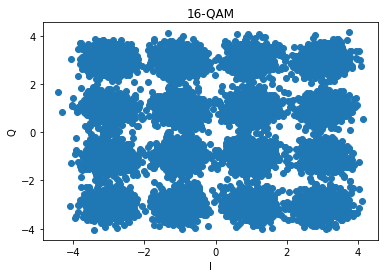

In [107]:
plt.plot(Xi_ch, Xr_ch, 'o')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('16-QAM')
plt.show()

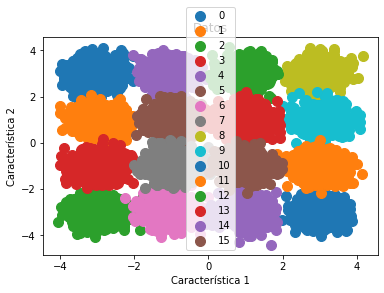

In [108]:
fig, ax = plt.subplots()
for g in np.unique(Symbols_tx):
    ix = np.where(Symbols_tx == g)
    ax.scatter(Xr_ch[ix], Xi_ch[ix], label = g, s = 100)
ax.legend()
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.title('Datos')
plt.show()

# Demodulación

In [109]:
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return(symbol)

In [110]:
sym_rx= demapper_sym(Xr_ch, Xi_ch, len(Xr_ch), threshold = 2.0)
print(sym_rx[0:10])


[7, 9, 2, 6, 12, 14, 12, 0, 9, 8]


In [111]:
#TAREA 3
y_pred_bin=[]
y_test_bin=[]
for i in range(10000):
  y_pred_bin.append(bin(sym_rx[i]))
  y_test_bin.append(bin(Symbols_tx[i]))
  if bin(sym_rx[i])!=bin(Symbols_tx[i]):
    print("Error :"+ bin(Symbols_tx[i]) + ", transmitido: "+bin(sym_rx[i]))
#print(y_pred_bin[0:10])
#print(y_test_bin[0:10])

Error :0b1000, transmitido: 0b1001
Error :0b1110, transmitido: 0b1111
Error :0b1110, transmitido: 0b110
Error :0b101, transmitido: 0b1101
Error :0b1000, transmitido: 0b1001
Error :0b1000, transmitido: 0b1001
Error :0b111, transmitido: 0b101
Error :0b101, transmitido: 0b100
Error :0b1100, transmitido: 0b1101
Error :0b111, transmitido: 0b11
Error :0b0, transmitido: 0b1
Error :0b1101, transmitido: 0b101
Error :0b1011, transmitido: 0b1010
Error :0b1010, transmitido: 0b1110
Error :0b111, transmitido: 0b1111
Error :0b1111, transmitido: 0b1101
Error :0b1101, transmitido: 0b1100
Error :0b10, transmitido: 0b110
Error :0b1101, transmitido: 0b1100
Error :0b110, transmitido: 0b10
Error :0b101, transmitido: 0b111
Error :0b100, transmitido: 0b101
Error :0b110, transmitido: 0b1110
Error :0b111, transmitido: 0b101
Error :0b100, transmitido: 0b0
Error :0b111, transmitido: 0b101
Error :0b0, transmitido: 0b1
Error :0b1110, transmitido: 0b110
Error :0b1000, transmitido: 0b1100
Error :0b1011, transmitido: 

In [112]:
def SER_f(sym_rx, Symbols_tx, Ns):
    error = 0
    for i in range(Ns):
        if sym_rx[i] == Symbols_tx[i]:
            error = error
        else:
            error= error + 1
    SER = error/Ns
    return([SER, error])

In [113]:
SER, error = SER_f(sym_rx, Symbols_tx, Ns)
print(SER)
print(error)

0.0062
62


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


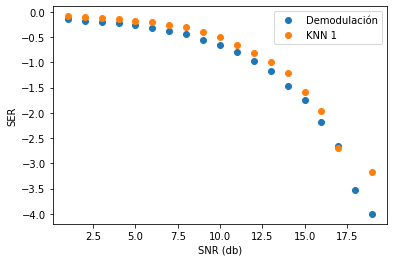

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


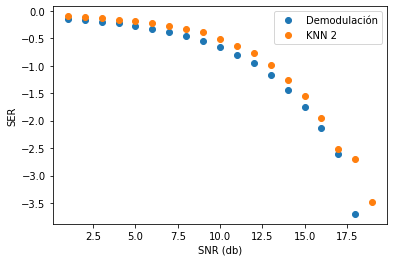

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


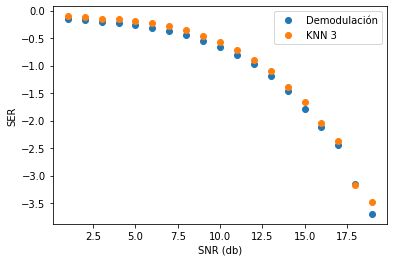

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


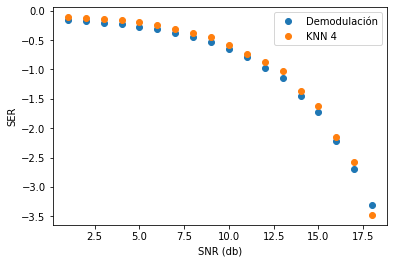

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


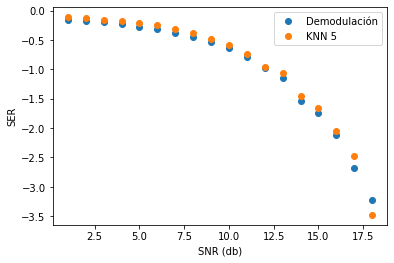

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


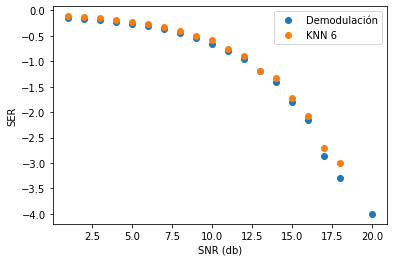

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


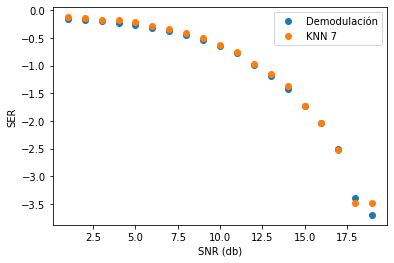

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


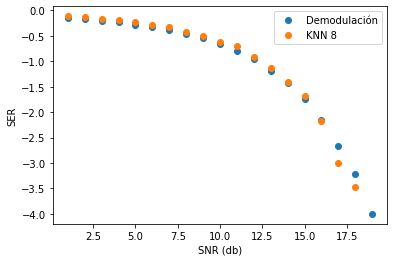

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


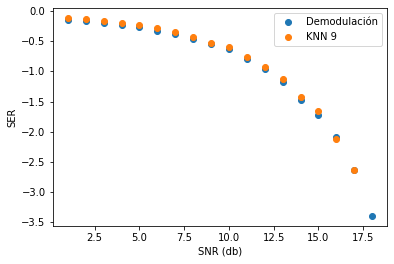

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


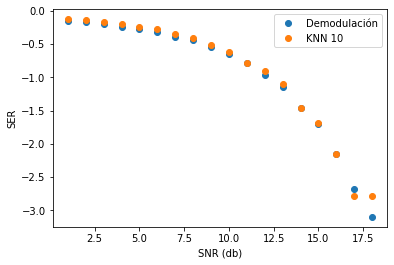

In [100]:
#TAREA 1 Y 2
from numpy import log10
for n in range(10):
  x=[]
  y=[]
  y2=[]
  for i in range(20):
    target_snr_db = i+1
    Xr_avg_p = np.mean(Xr**2)
    Xr_avg_db = 10 * np.log10(Xr_avg_p)
    #print(Xr_avg_db)
    noise_avg_db_r = Xr_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
    Xr_ch = Xr + noise_r
    Xi_avg_p = np.mean(Xi**2)
    Xi_avg_db = 10 * np.log10(Xi_avg_p)
    #print(Xi_avg_db)
    noise_avg_db_i = Xr_avg_db - target_snr_db
    noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
    noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
    Xi_ch = Xi + noise_i
    def SER(sym_rx, Symbols_tx, Ns):
      error = 0
      for i in range(Ns):
          if sym_rx[i] == Symbols_tx[i]:
              error = error
          else:
              error= error + 1
      SER = error/Ns
      return([SER, error])
    sym_rx= demapper_sym(Xr_ch, Xi_ch, len(Xr_ch), threshold = 2.0)
    SER, error = SER(sym_rx, Symbols_tx, Ns)
    y=np.append(y,log10(SER)) 
    #y=np.append(y,SER)  

    X_ = np.transpose(np.array([Xr_ch,Xi_ch]))
    y_= Symbols_tx
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3) # 70% training and 30% test
    k= n+1 # número de vecinos
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    model.score(X_train, y_train)
    y_pred = model.predict(X_test)
    SER_test, error_test = SER_f(y_pred, y_test, len(y_pred))
    #print(SER_test)
    x.append(i+1) 
    y2=np.append(y2,log10(SER_test))
    #y2=np.append(y2,SER_test)

  plt.plot(x, y, 'o',label = "Demodulación")
  plt.plot(x, y2, 'o',label = f"KNN {n+1}")
  plt.xlabel('SNR (dB)')
  plt.legend()
  plt.ylabel('SER')
  plt.show()

# Demodulación usando KNN

In [114]:
X = np.transpose(np.array([Xr_ch,Xi_ch]))
y= Symbols_tx

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [116]:
k= 10 # número de vecinos
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [117]:
model.score(X_train, y_train)

0.993

In [118]:
y_pred = model.predict(X_test)

In [119]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9943333333333333


In [120]:
print(y_pred[0:10])
print(y_test[0:10])

[ 3  6 12  5  3  9 13 10  5 10]
[ 3  6 12  5  3  9  5 10  5 10]


In [121]:
#TAREA 3
y_pred_bin=[]
y_test_bin=[]
for i in range(1000):
  y_pred_bin.append(bin(y_pred[i]))
  y_test_bin.append(bin(y_test[i]))
  if bin(y_pred[i])!=bin(y_test[i]):
    print("Error :"+ bin(y_pred[i]) + ", transmitido: "+bin(y_test[i]))
#print(y_pred_bin[0:10])
#print(y_test_bin[0:10])

Error :0b1101, transmitido: 0b101
Error :0b1001, transmitido: 0b1011
Error :0b10, transmitido: 0b110


In [122]:
SER_test, error_test = SER_f(y_pred, y_test, len(y_pred))

In [123]:
print(SER_test)
print(error_test)

0.005666666666666667
17
